<a href="https://colab.research.google.com/github/sara-i/CUBIG_Covid/blob/main/Covid19_2021_test%2Bvisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chest X-Ray Medical Diagnosis with Deep Learning**

## **KAGGLE DATASET:**
## COVID-19 Radiography Database [Click here](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
### (This dataset is used for model training)
---

- Ref for prob. prediction [Click here](https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/)


---



## **1. import packages and functions**

In [ ]:
#Data preprocessing
import numpy as np
import pandas as pd 
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from tqdm import tqdm
from PIL import Image
import os, random, cv2
from os import listdir
from IPython.display import display_html

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Activation, Flatten, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
import tensorflow.keras.layers as layers

class color:
    BOLD = '\033[1m' + '\033[94m'
    END = '\033[0m'

## **2. Mount this colab sheet with google drive (to import image and export some training weight)**
1. mount drive
2. display file name of covid dataset in our drive
3. unzip dataset
4. display all file that contain in zipfile
5. check some file name

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
listdir('/content/drive/MyDrive/aom_AI/Covid19')

['COVID-19_Radiography_Database.zip',
 'COVID19_pretrained_densenet121.ckpt',
 'COVID19_pretrained_new_densenet121.ckpt',
 'my_model_densenet_weights.h5',
 'my_model_densenet_weights_tuning.h5',
 'results']

In [ ]:
!unzip -q '/content/drive/MyDrive/aom_AI/Covid19/COVID-19_Radiography_Database.zip'

In [ ]:
listdir('COVID-19_Radiography_Dataset/')

['Lung_Opacity',
 'Lung_Opacity.metadata.xlsx',
 'Normal.metadata.xlsx',
 'Viral Pneumonia.metadata.xlsx',
 'Viral Pneumonia',
 'COVID.metadata.xlsx',
 'COVID',
 'README.md.txt',
 'Normal']

In [ ]:
# Read in metadata
Normal_excel = pd.read_excel("COVID-19_Radiography_Dataset/Normal.metadata.xlsx")
Covid_excel = pd.read_excel("COVID-19_Radiography_Dataset/COVID.metadata.xlsx")

print(color.BOLD + "Normal case Shape:" + color.END, Normal_excel.shape, "\n" +
      color.BOLD + "Covid case Shape:" + color.END, Covid_excel.shape, "\n")

# Head of our 2 training metadata
df1_styler = Normal_excel.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('NORMAL CASE')
df2_styler = Covid_excel.head(3).style.set_table_attributes("style='display:inline'").\
                                set_caption('COVID CASE')

display_html(df1_styler._repr_html_(), raw=True) 
display_html(df2_styler._repr_html_(), raw=True)

Normal case Shape: (10192, 4) 
Covid case Shape: (3616, 4) 



,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data


,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covid-19/
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covid-19/
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covid-19/


#### We will use DIR "Normal" and "COVID" ที่มี file .png อยู่ด้านใน และใช้ truth จาก file name


---


## **3. Data preparation**

1. create path name, normal case and COVID case
2. display some image from pathname that we created
3. create label (truth) from directory name

### **3.1 Create image path**

In [ ]:
NormalPaths = []
for dirname, _, filenames in os.walk('COVID-19_Radiography_Dataset/Normal/'):
    for filename in filenames:
        if (filename[:6] == 'Normal'):  #ถ้าในfile นั้นๆ ขึ้นต้นด้วย Normal ให้ save path ไว้ใน "NormalPaths"
            NormalPaths.append(os.path.join(dirname, filename))

COVIDPaths = []
for dirname, _, filenames in os.walk('COVID-19_Radiography_Dataset/COVID/'):
    for filename in filenames:
        if (filename[:5] == 'COVID'):  #ถ้าในfile นั้นๆ ขึ้นต้นด้วย COVID ให้ save path ไว้ใน "COVIDPaths"
            COVIDPaths.append(os.path.join(dirname, filename))

#Concat NormalPaths and COVIDPaths
all_ImagePath = NormalPaths + COVIDPaths

NomalPath: 10192 items // COVID-19_Radiography_Dataset/Normal/Normal-4587.png 
COVIDPath: 3616 items // COVID-19_Radiography_Dataset/COVID/COVID-2699.png 
all_ImagePath: 13808 items // COVID-19_Radiography_Dataset/Normal/Normal-4587.png 



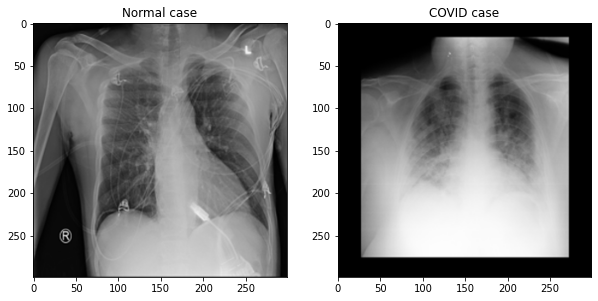

Image shape of normal case =  (299, 299, 3) 
Image shape of Covid case =  (299, 299, 3)


In [ ]:
#Number of CXR item and image path
print(color.BOLD + "NomalPath: {} items // ".\
            format(len(NormalPaths)) + color.END + NormalPaths[0],\
"\n" + color.BOLD + "COVIDPath: {} items // ".\
            format(len(COVIDPaths)) + color.END + COVIDPaths[0],
"\n" + color.BOLD + "all_ImagePath: {} items // ".\
            format(len(all_ImagePath)) + color.END + all_ImagePath[0],
"\n")

#display some image
normal_image = cv2.imread(NormalPaths[0]) #ยกตัวอย่าง case ที่ 1 ใน Normal file
covid_image = cv2.imread(COVIDPaths[0]) #ยกตัวอย่าง case ที่ 1 ใน COVID file

plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1); plt.imshow(normal_image), plt.title("Normal case")
plt.subplot(1, 2, 2); plt.imshow(covid_image), plt.title("COVID case")
plt.show()

print(color.BOLD + "Image shape of normal case = " + color.END, normal_image.shape,\
"\n" + color.BOLD + "Image shape of Covid case = " + color.END, covid_image.shape)


---

## **/// Initial training (Create only 2000 cases per class) ///**



In [ ]:
#Keep only 2000 of normal case and 2000 of Covid case.
#For X (image)
COVIDPaths_2000 = COVIDPaths[:2000]
NormalPaths_2000 = NormalPaths[:2000]
all_ImagePath_2000 = COVIDPaths_2000 + NormalPaths_2000

In [ ]:
del COVIDPaths, NormalPaths, all_ImagePath

## **/// Delete above when run all dataset ///**

### **(อย่าลืมเปลี่ยน all_ImagePath_2000 >> all_ImagePath)**


---



## Write image ให้น้อง + ต่อไปถ้าจะ training dataset น้องให้ใช้อันนี้



```
DIR_FOR_SEG = '/content/drive/MyDrive/aom_AI/Covid19/Dataset_for_segmentation/'
```



In [ ]:
all_ImagePath_2000[0]

'COVID-19_Radiography_Dataset/COVID/COVID-2699.png'

In [ ]:
DIR_FOR_SEG = '/content/drive/MyDrive/aom_AI/Covid19/Dataset_for_segmentation/'

for i in all_ImagePath_2000: #
    img = cv2.imread(i)
    write = cv2.imwrite(DIR_FOR_SEG + i.split(os.path.sep)[-1], img)

In [ ]:
# For patient number
case_no = []

for i in all_ImagePath_2000: #
    img = cv2.imread(i)
    write = cv2.imwrite(DIR_FOR_SEG + i.split(os.path.sep)[-1], img)
    i.split("-")[1]
    i.split(".")[0]
    
    
    s1.split(':')
    i.split(os.path.sep)[-5]


### **3.2 Create label**

In [ ]:
X = [] #create image dataset that contain both normal and COVID
y = [] #create label in each case

for i in all_ImagePath_2000: #
    #split path แยกระหว่าง file dir กับ file name ออกจากกัน (-1)คือตำแหน่งชื่อ file Normal/COVID-xxx.png
    label = i.split(os.path.sep)[-1].split('-')[0] 
    img = cv2.imread(i)
    img = tf.image.resize(img, (224, 224))
    #put label and image into X and y list
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
import collections
counter=collections.Counter(y)
print(dict(counter))

{'COVID': 2000, 'Normal': 2000}


In [ ]:
pd.DataFrame(y)
y = pd.get_dummies(y)

In [ ]:
y.columns = ["COVID", "Normal"]
print(y.head(3),\
"\n", y.tail(3))

print(color.BOLD + "Number of COVID case after get_dummies:" + color.END, y["COVID"].sum(),\
"\n"+ color.BOLD + "Number of Normal case after get_dummies:" + color.END, y["Normal"].sum())

   COVID  Normal
0      1       0
1      1       0
2      1       0 
       COVID  Normal
3997      0       1
3998      0       1
3999      0       1
Number of COVID case after get_dummies: 2000 
Number of Normal case after get_dummies: 2000


##**สรุป**
ตอนนี้เรามี ....
1. **" X "** contained all image เป็น matrix แล้ว (both normal and COVID case)
2. **" y "** contained all truth เป็นค่า 0/1 (both normal and COVID case)

## Split data into 70-20-10 train-val-test
โดยใช้ input = X (image data) , output = y_onehot (truth)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, \
                                                    shuffle = True, random_state = 9559)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, \
                                                  shuffle = True, random_state = 9559)

In [ ]:
#Recheck จำนวนทั้งหมด
print(color.BOLD + "Training set: " + color.END, len(X_train), "cases",\
"\n"+ color.BOLD + "Validation set: " + color.END, len(X_val), "cases",\
"\n"+ color.BOLD + "Test set: " + color.END, len(X_test), "cases")

Training set:  2880 cases 
Validation set:  720 cases 
Test set:  400 cases


In [ ]:
del X

In [ ]:
#image shape
X_train.shape

(2880, 224, 224, 3)

## Download and prepare Neural Network
*  Model : Densenet121
*  Weights : trained model

In [ ]:
def new_cxr_pretrained_densenet121():
    base_model = tf.keras.applications.DenseNet121(input_shape = (224, 224, 3), weights = None , include_top = False)
    base_model.trainable = True ## Unfreeze convolutional part

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(2, activation = 'sigmoid')(x)
    model = tf.keras.Model(base_model.input, outputs = x)

    return model  

In [ ]:
new_cxr_pretrained_densenet = new_cxr_pretrained_densenet121()

In [ ]:
#load weight 
CHECK_POINT = '/content/drive/MyDrive/aom_AI/Covid19'
new_cxr_pretrained_densenet.load_weights(CHECK_POINT + '/my_model_densenet_weights_tuning.h5')

In [ ]:
#compile model
new_cxr_pretrained_densenet.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-5), metrics = ['accuracy'])

In [ ]:
#predict y in validation set
y_val_pred = new_cxr_pretrained_densenet.predict(X_val)
print('prediction accuracy on validation set after fine-tuning:', accuracy_score(y_val, y_val_pred > 0.5))

prediction accuracy on validation set after fine-tuning: 0.9430555555555555


Evaluate model performance on test set : 

In [ ]:
#predict y in test set
y_test_pred = new_cxr_pretrained_densenet.predict(X_test)
print('prediction accuracy on test set after fine-tuning:', accuracy_score(y_test, y_test_pred > 0.5))

prediction accuracy on test set after fine-tuning: 0.9425


In [ ]:
# Recheck probability outcomes
for i in range(len(X_val)):
	print("Case no.%s, Predicted=%s" % (i+1, y_val_pred[i]))

Case no.1, Predicted=[0.07509321 0.96822345]
Case no.2, Predicted=[0.99815047 0.00668806]
Case no.3, Predicted=[0.0280838 0.9449848]
Case no.4, Predicted=[6.5752864e-04 9.9930823e-01]
Case no.5, Predicted=[0.01714042 0.98044056]
Case no.6, Predicted=[0.00141346 0.99768746]
Case no.7, Predicted=[0.76751846 0.5667779 ]
Case no.8, Predicted=[0.01924133 0.961128  ]
Case no.9, Predicted=[2.3447257e-05 9.9993515e-01]
Case no.10, Predicted=[0.019795   0.99802387]
Case no.11, Predicted=[9.452845e-01 1.796782e-04]
Case no.12, Predicted=[2.9337406e-04 9.9989963e-01]
Case no.13, Predicted=[1.00000e+00 1.64725e-06]
Case no.14, Predicted=[0.00178948 0.993492  ]
Case no.15, Predicted=[0.00225565 0.9970335 ]
Case no.16, Predicted=[0.87520397 0.09514394]
Case no.17, Predicted=[0.0070059 0.9408521]
Case no.18, Predicted=[0.18781146 0.9752111 ]
Case no.19, Predicted=[0.00131917 0.99905074]
Case no.20, Predicted=[9.999943e-01 6.064537e-05]
Case no.21, Predicted=[0.9986476  0.00247222]
Case no.22, Predict

In [ ]:
del result

In [ ]:
result = []
for i in range(len(X_val)):
  result.append(y_val_pred[i]) # for prob. of prediction outcomes
  
result = pd.DataFrame(result, columns=['Covid', 'Normal',])
result.head()

,Covid,Normal
0,0.075093,0.968223
1,0.998150,0.006688
2,0.028084,0.944985
3,0.000658,0.999308
4,0.017140,0.980441


In [ ]:
y_val = pd.DataFrame(y_val)
y_val.shape

(720, 2)

In [ ]:
result2 = pd.concat([result, y_val], axis = 1)

AttributeError: ignored

In [ ]:
del result2

In [ ]:
print(result2)

         Covid    Normal  COVID  Normal
0     0.075093  0.968223    1.0     0.0
1     0.998150  0.006688    1.0     0.0
2     0.028084  0.944985    NaN     NaN
3     0.000658  0.999308    1.0     0.0
4     0.017140  0.980441    NaN     NaN
...        ...       ...    ...     ...
3989       NaN       NaN    0.0     1.0
3990       NaN       NaN    0.0     1.0
3991       NaN       NaN    0.0     1.0
3992       NaN       NaN    0.0     1.0
3994       NaN       NaN    0.0     1.0

[1299 rows x 4 columns]


In [ ]:
# export to excel
result_path = '/content/drive/MyDrive/aom_AI/Covid19/results/'
result.to_excel(result_path +"results.xlsx", index=True)

In [ ]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

In [ ]:
heatmap = GradCAM(new_cxr_pretrained_densenet, y_val_pred[0], layerName=None)

AttributeError: ignored

## ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test,\
                                                            y_test_pred_new)
auc_keras = auc(nn_fpr_keras,\
                nn_tpr_keras)
plt.plot(nn_fpr_keras,\
         nn_tpr_keras,\
         marker='.',\
         label='Neural Network (auc = %0.3f)' % auc_keras)



ValueError: ignored

## Visualizing learning with GradCam

In [ ]:
!pip3 install utils

In [ ]:
#df = pd.read_csv("nih/train-small.csv")
#IMAGE_DIR = "nih/images-small/"
labels = ['Covid', 'Normal']

# only show the lables with top 4 AUC
#labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
from utils import *
import utils
utils.compute_gradcam(new_cxr_pretrained_densenet, X_test[0], labels)

AttributeError: ignored

In [ ]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels)